In [121]:
import numpy as np
import matplotlib.pyplot as plt
import sampler as sampler
import scipy.integrate as integrate
from scipy.misc import derivative
import nlopt
# from numpy import *

### Step 1

Create underlying distribution

In [122]:
def distribution(x):
    return np.exp(-(x-6)**2/2)/np.sqrt(2*np.pi)

### Step 2

Take 1000 samples

In [123]:
distribution_sampler = sampler.Sampler(distribution, 1000)
samples = distribution_sampler.sample(1000)

### Step 3

Create bins (at the moment I'm creating fixed bins that will not depend on the samples, but I'll try something different later)

In [124]:
lower_bound, upper_bound = distribution_sampler.integral.get_end_points()
bins = np.linspace(lower_bound+3, upper_bound-3, 201)

In [125]:
histogram = []

for i in range(1, len(bins)):
    num = 0
    for sample in samples:
        if sample > bins[i-1] and sample < bins[i]:
            num += 1
    histogram.append(num)



### Step 4

Create likelihoods. Right: Multinomial. Approximations: Poisson, Gaussian

Multinomial: $L_{MN} (x|\mu) = \left( {\begin{array}{c}  M \\ n_1!n_2!...n_N! \end{array} } \right) {\displaystyle \prod_{i=1}^{N} P(x|\mu)^{n_i} }$

In [126]:
def mn_log_likelihood(avg, grad):

    # print(avg)
    # print(grad)
    mu = avg[0]

    def gaussian(x, y):
        return np.exp(-(x - y)**2)/np.sqrt(2*np.pi)

    likelihood = 0
    for i in range(len(histogram)):
        likelihood += histogram[i]*np.log(integrate.quad(gaussian, bins[i], bins[i+1], args=(mu))[0])
    
    likelihood *= -2

    if grad.size > 0:
        derivative = [0]
        for i in range(len(histogram)):
            derivative[0] += histogram[i]*(gaussian(bins[i+1], mu) - gaussian(bins[i], mu))
        derivative[0] *= 2
        grad[:] = derivative

    # print(likelihood)
    # print(derivative)

    return likelihood




In [127]:
# Trying to maximize the likelihood with nlopt

opt = nlopt.opt(nlopt.GN_DIRECT_L, 1)

opt.set_min_objective(mn_log_likelihood)
opt.set_lower_bounds(0)
opt.set_upper_bounds(12)
opt.set_ftol_rel(1e-10)
opt.set_xtol_rel(1e-10)

mu_opt = opt.optimize([5])

### Step 5

Repeat 1000 times

In [128]:
N = 100

mu_opt_total_mn = []
bins = np.linspace(lower_bound, upper_bound, 401)

for i in range(N):
    samples = distribution_sampler.sample(N)

    histogram = []
    for i in range(1, len(bins)):
        num = 0
        for sample in samples:
            if sample > bins[i-1] and sample < bins[i]:
                num += 1
        histogram.append(num)


    opt = nlopt.opt(nlopt.GN_DIRECT_L, 1)
    opt.set_min_objective(mn_log_likelihood)
    opt.set_lower_bounds(0)
    opt.set_upper_bounds(12)
    opt.set_ftol_rel(1e-10)
    opt.set_xtol_rel(1e-10)

    mu_opt_total_mn.append(opt.optimize([5])[0])


(array([0.76060311, 2.09165856, 2.09165856, 4.56361867, 3.80301556,
        2.66211089, 1.711357  , 0.57045233, 0.57045233, 0.19015078]),
 array([5.7920296 , 5.84461944, 5.89720929, 5.94979913, 6.00238898,
        6.05497882, 6.10756867, 6.16015851, 6.21274836, 6.2653382 ,
        6.31792805]),
 <BarContainer object of 10 artists>)

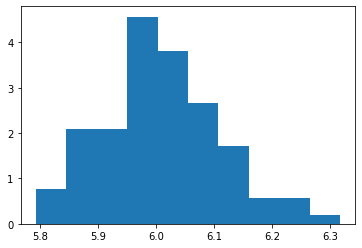

In [129]:
plt.hist(mu_opt_total_mn, bins=10, density=True)

In [130]:
mu_opt_avg_mn = sum(mu_opt_total_mn)/len(mu_opt_total_mn)

mu_opt_var_mn = 0
for mu_i in mu_opt_total_mn:
    mu_opt_var_mn += (mu_i - mu_opt_avg_mn)**2

mu_opt_var_mn /= len(mu_opt_total_mn) +1

print(mu_opt_avg_mn, mu_opt_var_mn)

6.0105539885372465 0.009972350419339021


In [131]:
def p_log_likelihood(avg, grad):
    mu = avg[0]

    def gaussian(x, y):
        return np.exp(-(x - y)**2)/np.sqrt(2*np.pi)

    likelihood = 0
    for i in range(len(histogram)):
        P_i = integrate.quad(gaussian, bins[i], bins[i+1], args=(mu))[0]
        likelihood += P_i - histogram[i]*np.log(P_i)
    
    likelihood *= 2

    # if grad.size > 0:
    #     derivative = [0]
    #     for i in range(len(histogram)):
    #         derivative[0] += histogram[i]*(gaussian(bins[i+1], mu) - gaussian(bins[i], mu))
    #     derivative[0] *= 2
    #     grad[:] = derivative

    # print(likelihood)
    # print(derivative)

    return likelihood




In [132]:
mu_opt_total_p = []

for i in range(N):
    samples = distribution_sampler.sample(N)

    histogram = []
    for i in range(1, len(bins)):
        num = 0
        for sample in samples:
            if sample > bins[i-1] and sample < bins[i]:
                num += 1
        histogram.append(num)


    opt = nlopt.opt(nlopt.GN_DIRECT_L, 1)
    opt.set_min_objective(p_log_likelihood)
    opt.set_lower_bounds(0)
    opt.set_upper_bounds(12)
    opt.set_ftol_rel(1e-10)
    opt.set_xtol_rel(1e-10)

    mu_opt_total_p.append(opt.optimize([5])[0])


(array([1.4558432 , 2.91168639, 3.88224852, 4.85281065, 2.66904586,
        2.91168639, 3.15432692, 1.21320266, 0.7279216 , 0.48528107]),
 array([5.84027578, 5.88148901, 5.92270224, 5.96391547, 6.0051287 ,
        6.04634193, 6.08755516, 6.12876839, 6.16998162, 6.21119485,
        6.25240808]),
 <BarContainer object of 10 artists>)

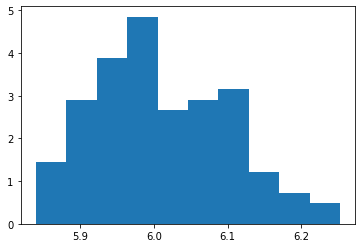

In [133]:
plt.hist(mu_opt_total_p, bins=10, density=True)

In [134]:
mu_opt_avg_p = sum(mu_opt_total_p)/len(mu_opt_total_p)

mu_opt_var_p = 0
for mu_i in mu_opt_total_p:
    mu_opt_var_p += (mu_i - mu_opt_avg_p)**2

mu_opt_var_p /= len(mu_opt_total_p) +1

print(mu_opt_avg_p, mu_opt_var_p)

6.008973682029501 0.00782119054592757


(array([0.76060311, 2.09165856, 2.09165856, 4.56361867, 3.80301556,
        2.66211089, 1.711357  , 0.57045233, 0.57045233, 0.19015078]),
 array([5.7920296 , 5.84461944, 5.89720929, 5.94979913, 6.00238898,
        6.05497882, 6.10756867, 6.16015851, 6.21274836, 6.2653382 ,
        6.31792805]),
 <BarContainer object of 10 artists>)

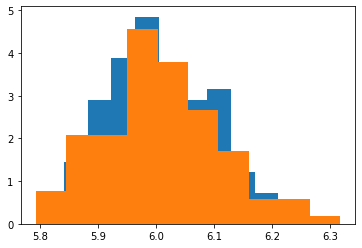

In [135]:
plt.hist(mu_opt_total_p, bins=10, density=True)
plt.hist(mu_opt_total_mn, bins=10, density=True)

In [136]:
def g_log_likelihood(avg, grad):

    # print(avg)
    # print(grad)
    mu = avg[0]

    def gaussian(x, y):
        return np.exp(-(x - y)**2)/np.sqrt(2*np.pi)

    likelihood = 0
    for i in range(len(histogram)):
        P_i = integrate.quad(gaussian, bins[i], bins[i+1], args=(mu))[0]
        likelihood += histogram[i]**2/P_i**2 - 2*histogram[i]/P_i
    
    # likelihood *= 2

    # if grad.size > 0:
    #     derivative = [0]
    #     for i in range(len(histogram)):
    #         derivative[0] += histogram[i]*(gaussian(bins[i+1], mu) - gaussian(bins[i], mu))
    #     derivative[0] *= 2
    #     grad[:] = derivative

    # print(likelihood)
    # print(derivative)

    return likelihood




In [137]:
mu_opt_total_g = []

for i in range(N):
    samples = distribution_sampler.sample(N)

    histogram = []
    for i in range(1, len(bins)):
        num = 0
        for sample in samples:
            if sample > bins[i-1] and sample < bins[i]:
                num += 1
        histogram.append(num)


    opt = nlopt.opt(nlopt.GN_DIRECT_L, 1)
    opt.set_min_objective(p_log_likelihood)
    opt.set_lower_bounds(0)
    opt.set_upper_bounds(12)
    opt.set_ftol_rel(1e-10)
    opt.set_xtol_rel(1e-10)

    mu_opt_total_g.append(opt.optimize([5])[0])


In [138]:
mu_opt_avg_g = sum(mu_opt_total_g)/len(mu_opt_total_g)

mu_opt_var_g = 0
for mu_i in mu_opt_total_g:
    mu_opt_var_g += (mu_i - mu_opt_avg_g)**2

mu_opt_var_g /= len(mu_opt_total_g) +1

print(mu_opt_avg_g, mu_opt_var_g)

6.009116607975788 0.009505856663578173


(array([1.23836684, 2.88952262, 2.47673367, 5.98543971, 2.88952262,
        2.47673367, 1.23836684, 0.61918342, 0.41278895, 0.41278895]),
 array([5.82452991, 5.87298082, 5.92143173, 5.96988264, 6.01833355,
        6.06678446, 6.11523537, 6.16368628, 6.21213719, 6.2605881 ,
        6.30903901]),
 <BarContainer object of 10 artists>)

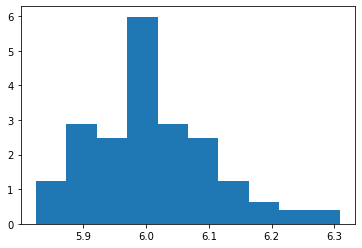

In [139]:
plt.hist(mu_opt_total_g, bins=10, density=True)

6.0105539885372465 0.009972350419339021
6.008973682029501 0.00782119054592757
6.009116607975788 0.009505856663578173


(array([1.23836684, 2.88952262, 2.47673367, 5.98543971, 2.88952262,
        2.47673367, 1.23836684, 0.61918342, 0.41278895, 0.41278895]),
 array([5.82452991, 5.87298082, 5.92143173, 5.96988264, 6.01833355,
        6.06678446, 6.11523537, 6.16368628, 6.21213719, 6.2605881 ,
        6.30903901]),
 <BarContainer object of 10 artists>)

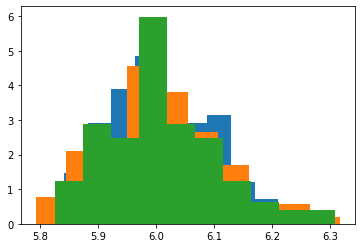

In [140]:
print(mu_opt_avg_mn, mu_opt_var_mn)
print(mu_opt_avg_p, mu_opt_var_p)
print(mu_opt_avg_g, mu_opt_var_g)

plt.hist(mu_opt_total_p, bins=10, density=True)
plt.hist(mu_opt_total_mn, bins=10, density=True)
plt.hist(mu_opt_total_g, bins=10, density=True)
